

.
# Лабораторная работа №4. Кластеризация
## Постановка цели и задачи

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

In [3]:
# Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, adjusted_mutual_info_score, jaccard_score
)
from sklearn.feature_selection import mutual_info_classif

### Загрузка и первичный осмотр датасета

В этом блоке происходит загрузка набора данных `Automobile.csv` и первичный осмотр содержимого.

- **Файл:** `Automobile.csv`
- **Размер данных:** 398 строк и 9 столбцов (после первичной очистки и обработки пропусков)
- **Признаки в датасете:**
  - `name` — название автомобиля (категориальный)
  - `mpg` — расход топлива (миль на галлон, числовой)
  - `cylinders` — количество цилиндров (числовой)
  - `displacement` — объём двигателя (числовой)
  - `horsepower` — мощность (числовой)
  - `weight` — вес автомобиля (числовой)
  - `acceleration` — ускорение (числовой)
  - `model_year` — год модели (числовой)
  - `origin` — страна происхождения (категориальный)
- **Особенности файла:**
  - Разделитель значений — `;`
  - Десятичная запятая `,` используется для числовых значений
  - Кодировка файла — `latin1` (для корректного отображения символов)
- **Действия в коде:**
  1. С помощью `pd.read_csv` загружаем данные с учётом особенностей разделителя и десятичного формата.
  2. Выводим размер датасета (`data.shape`) для понимания числа строк и столбцов.
  3. Отображаем первые 5 строк таблицы (`data.head()`), чтобы быстро ознакомиться с форматом данных и наличием пропусков.

**Вывод:**  
Датасет содержит информацию о технических характеристиках различных автомобилей, включая расход топлива, мощность, вес, ускорение и год выпуска. Эти признаки будут использоваться для дальнейшего анализа и кластеризации автомобилей по техническим характеристикам.


In [4]:
# Загрузка датасета
file_path = "Automobile.csv"

# В датасете есть разделитель ';' и десятичная запятая, учтем это
data = pd.read_csv(file_path, sep=';', decimal=',', encoding='latin1')

# Быстрый осмотр
print("Размер данных:", data.shape)
print(data.head())

Размер данных: (398, 1)
  name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0  chevrolet chevelle malibu,18,8,307,130,3504,12...                              
1    buick skylark 320,15,8,350,165,3693,11.5,70,usa                              
2     plymouth satellite,18,8,318,150,3436,11,70,usa                              
3          amc rebel sst,16,8,304,150,3433,12,70,usa                              
4          ford torino,17,8,302,140,3449,10.5,70,usa                              


### Дескриптивный анализ и обработка пропусков

В этом блоке проводится первичный анализ данных и обработка отсутствующих значений.

- **Действия в коде:**
  1. Загружаем датасет `automobile.csv` с помощью `pd.read_csv`.
  2. Выполняем **дескриптивный анализ**:
     - Проверяем типы столбцов (`data.dtypes`).
     - Определяем количество пропущенных значений в каждом столбце (`data.isnull().sum()`).
     - Получаем базовую статистику по числовым признакам (`data.describe().T`).
  3. **Обработка пропусков**:
     - Для числовых колонок пропуски заполняются медианой (`fillna(data[numeric_cols].median())`).
     - Для категориальных колонок (например, `name`) строки с пропусками удаляются (`dropna(subset=['name'])`).
  4. Проверяем результаты обработки:
     - Размер датасета после очистки.
     - Отсутствие пропусков по столбцам.
     - Обновленная статистика по числовым признакам.

- **Цель блока:** подготовить датасет к дальнейшему анализу и кластеризации, обеспечив корректные числовые значения и отсутствие пропусков.


In [5]:
import pandas as pd
import numpy as np

# Загружаем данные
data = pd.read_csv('automobile.csv')

# Дескриптивный анализ
print("Типы столбцов:\n", data.dtypes)
print('\nПропуски по столбцам:\n', data.isnull().sum())
print('\nСтатистика по числовым признакам:\n', data.describe().T)

# Пропуски до обработки
print('\nПропуски по столбцам:\n', data.isnull().sum())

# Заполняем пропуски в числовых колонках медианой
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Если есть категориальные пропуски (например, name), можно удалить строки с ними
data_clean = data.dropna(subset=['name'])

# Проверка после обработки
print("\nРазмер данных после обработки пропусков:", data_clean.shape)
print('\nПропуски по столбцам после обработки:\n', data_clean.isnull().sum())

# Статистика по числовым признакам
print('\nСтатистика по числовым признакам:\n', data_clean.describe().T)


Типы столбцов:
 name             object
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
dtype: object

Пропуски по столбцам:
 name            0
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

Статистика по числовым признакам:
               count         mean         std     min       25%     50%  \
mpg           398.0    23.514573    7.815984     9.0    17.500    23.0   
cylinders     398.0     5.454774    1.701004     3.0     4.000     4.0   
displacement  398.0   193.425879  104.269838    68.0   104.250   148.5   
horsepower    392.0   104.469388   38.491160    46.0    75.000    93.5   
weight        398.0  2970.424623  846.841774  1613.0  2223.750  2803.5   
acceleration  398.0    15.568090    2.757689     8.0    13.825    15.5   
m

### Результаты дескриптивного анализа и обработки пропусков

В результате выполнения блока дескриптивного анализа получены следующие сведения о датасете `automobile.csv`:

1. **Типы столбцов:**

| Столбец        | Тип данных |
|----------------|------------|
| name           | object     |
| mpg            | float64    |
| cylinders      | int64      |
| displacement   | float64    |
| horsepower     | float64    |
| weight         | int64      |
| acceleration   | float64    |
| model_year     | int64      |
| origin         | object     |

2. **Пропуски по столбцам (до обработки):**

- `horsepower` содержит 6 пропущенных значений.
- Остальные столбцы не имеют пропусков.

3. **Статистика по числовым признакам (до обработки):**

- Средние значения, стандартное отклонение, минимальные, максимальные и квартильные значения для всех числовых признаков автомобилей.
- Например, средний расход топлива (`mpg`) — 23.5, средний вес (`weight`) — 2970.4, средний `horsepower` — 104.5.

4. **Обработка пропусков:**

- Пропуски в числовых признаках заполнены медианой.
- Пропуски в категориальных признаках (например, `name`) удалены.
- После обработки размер данных составил **398 строк и 9 столбцов**.
- Пропусков больше не осталось.

5. **Статистика по числовым признакам (после обработки):**

- `horsepower` теперь заполнен медианой, количество значений в столбце стало 398.
- Средние, минимальные, максимальные и квартильные значения числовых признаков практически не изменились, что подтверждает корректное восстановление пропущенных данных.

**Вывод:** датасет подготовлен для дальнейшего анализа и кластеризации, все числовые признаки заполнены, отсутствуют пропуски.


### Визуализация распределений числовых признаков и оценка асимметрии

В этом блоке проводим углублённый анализ числовых признаков автомобилей:

1. **Обрабатываем пропуски:**
   - Для числовых колонок `mpg`, `displacement`, `horsepower`, `weight`, `acceleration` пропущенные значения преобразуются в числовой формат (`pd.to_numeric`) и заполняются медианой.

2. **Визуализация распределений:**
   - Для каждого признака строятся два графика:
     - **Гистограмма с KDE** (ядровая оценка плотности), которая показывает форму распределения данных.
     - **Boxplot (ящик с усами)**, который визуализирует медиану, квартильные значения и выбросы.
   - Графики помогают выявить скошенность распределений, наличие выбросов и общее распределение признаков.

3. **Расчёт статистических характеристик:**
   - **Асимметрия (skewness)** показывает скошенность распределения:
     - Положительное значение — скошенность вправо.
     - Отрицательное значение — скошенность влево.
   - **Эксцесс (kurtosis)** оценивает "пиковость" распределения:
     - Значение > 0 — более острый пик, чем у нормального распределения.
     - Значение < 0 — более плоское распределение.
   - Выводятся значения `skew` и `kurtosis` для каждого числового признака.

**Выводы:**
- Визуализация и статистические метрики помогают оценить характер распределения данных и выявить признаки, требующие нормализации или трансформации перед кластеризацией.
- Также позволяет заранее заметить потенциальные выбросы, которые могут повлиять на качество кластеризации.


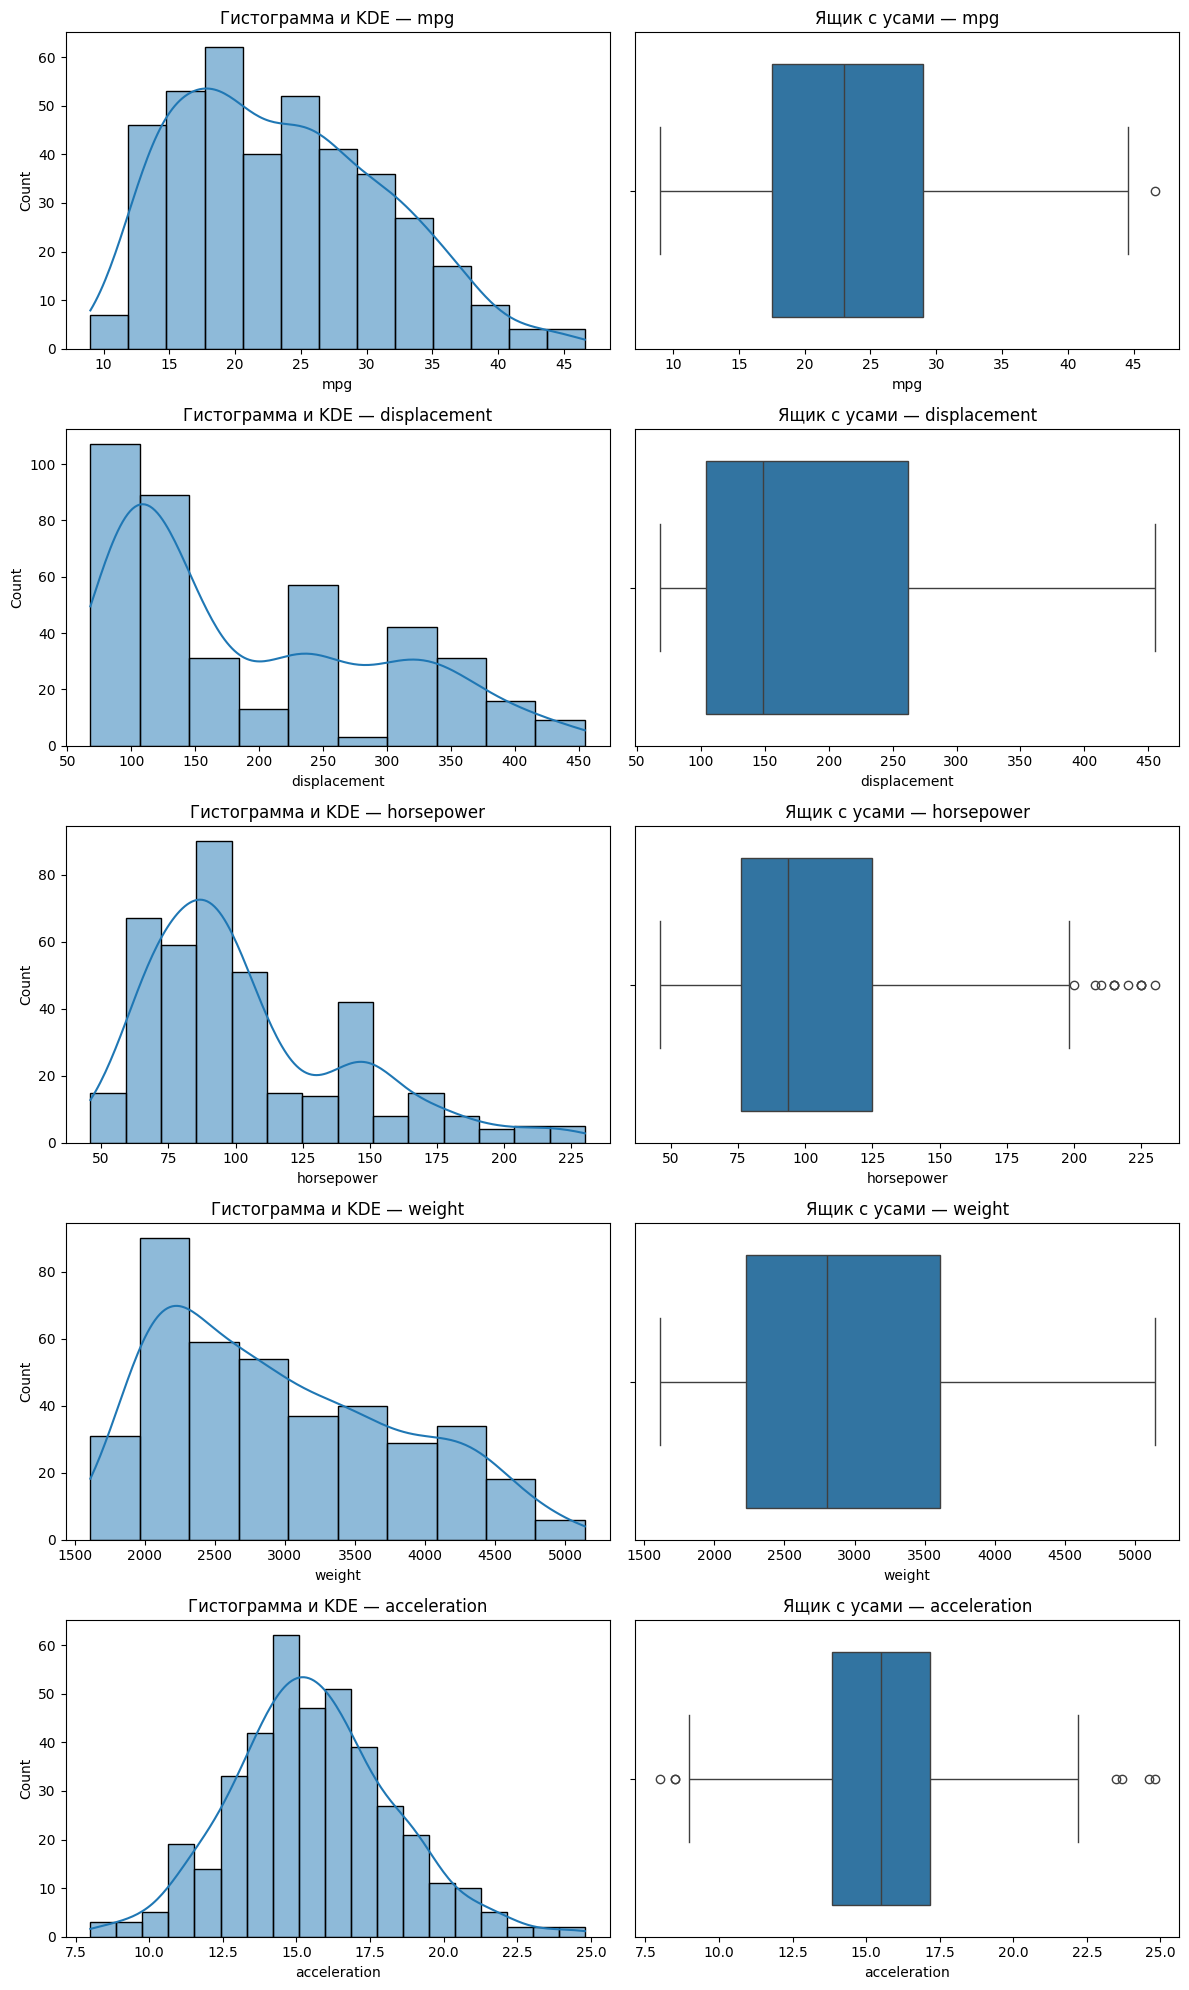

mpg: skew=0.455, kurtosis=-0.519
displacement: skew=0.717, kurtosis=-0.752
horsepower: skew=1.102, kurtosis=0.739
weight: skew=0.529, kurtosis=-0.791
acceleration: skew=0.278, kurtosis=0.399


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd

# Загружаем данные
data = pd.read_csv('automobile.csv')

# Обрабатываем пропуски
numeric_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')  # на случай строковых значений
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Визуализация
fig, axs = plt.subplots(len(numeric_cols), 2, figsize=(12, 4*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    col_data = data[col].astype(float)

    # Гистограмма + KDE
    sns.histplot(col_data, kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Гистограмма и KDE — {col}')

    # Boxplot
    sns.boxplot(x=col_data, ax=axs[i, 1])
    axs[i, 1].set_title(f'Ящик с усами — {col}')

plt.tight_layout()
plt.show()

# Расчёт асимметрии и эксцесса
for col in numeric_cols:
    col_data = data[col].astype(float)
    print(f"{col}: skew={skew(col_data):.3f}, kurtosis={kurtosis(col_data):.3f}")


### Результаты визуализации и статистического анализа числовых признаков

После выполнения блока кода были получены следующие результаты:

1. **Гистограммы с KDE и boxplot:**
   - Для каждого числового признака (`mpg`, `displacement`, `horsepower`, `weight`, `acceleration`) построены графики:
     - **Гистограмма с KDE** показывает распределение значений и наличие скосов.
     - **Boxplot** наглядно демонстрирует медиану, квартильные значения и выбросы.
   - Например:
     - `horsepower` и `acceleration` имеют выбросы, что видно по "усам" на boxplot.
     - `mpg` и `acceleration` имеют относительно симметричные распределения.

2. **Статистика асимметрии (skew) и эксцесса (kurtosis):**
   
| Признак       | Skew  | Kurtosis |
|---------------|-------|----------|
| mpg           | 0.455 | -0.519   |
| displacement  | 0.717 | -0.752   |
| horsepower    | 1.102 | 0.739    |
| weight        | 0.529 | -0.791   |
| acceleration  | 0.278 | 0.399    |

**Интерпретация:**

- **Асимметрия (skew)**:
  - Значения положительные для всех признаков, что означает **легкую скошенность вправо**.
  - Наиболее выражена скошенность у `horsepower` (1.102), остальные признаки умеренно скошены.

- **Эксцесс (kurtosis)**:
  - Отрицательные значения (`mpg`, `displacement`, `weight`) показывают более **плоское распределение** по сравнению с нормальным.
  - Положительные значения (`horsepower`, `acceleration`) указывают на **более острый пик распределения**.
  

**Выводы:**
- Распределения некоторых признаков сильно скошены и содержат выбросы (`horsepower`, `weight`, `mpg`), что следует учитывать при масштабировании и кластеризации.
- Признаки с близкими к нормальному распределением значениями (`mpg`, `acceleration`) не требуют дополнительной трансформации.
- Этот анализ помогает выбрать подходящие методы предобработки данных перед применением алгоритмов кластеризации.


### Оценка значимости признаков и подготовка к кластеризации

В этом блоке проводится предварительная оценка числовых признаков и проверка условий для применения методов кластеризации.

1. **Выбор числовых признаков:**
   - Для анализа выбраны признаки: `mpg`, `displacement`, `horsepower`, `weight`, `acceleration`.
   - Пропуски в этих признаках заполнены медианой, а данные приведены к числовому типу.

2. **Оценка информационной значимости признаков:**
   - Используется **дисперсия** каждого признака как оценка важности.
   - Признак с большей дисперсией вносит больше различий между объектами, что делает его более информативным для кластеризации.
   - Выводится таблица дисперсий по убыванию.

3. **Корреляционный анализ:**
   - Строится **корреляционная матрица** признаков с помощью тепловой карты (`heatmap`).
   - Позволяет выявить сильно коррелированные признаки, что может повлиять на результаты кластеризации.
   
4. **Проверка условий для кластеризации:**
   - **Наличие классов:** отсутствуют, что соответствует задаче кластеризации.
   - **Осмысленность:** признаки числовые и разнородные, кластеризация возможна.
   - **Выбросы:** выявлены ранее с помощью boxplot; при необходимости их можно дополнительно фильтровать.



Дисперсия числовых признаков (чем выше — тем больше различий между объектами):

weight          717140.990526
displacement     10872.199152
horsepower        1460.969052
mpg                 61.089611
acceleration         7.604848
dtype: float64


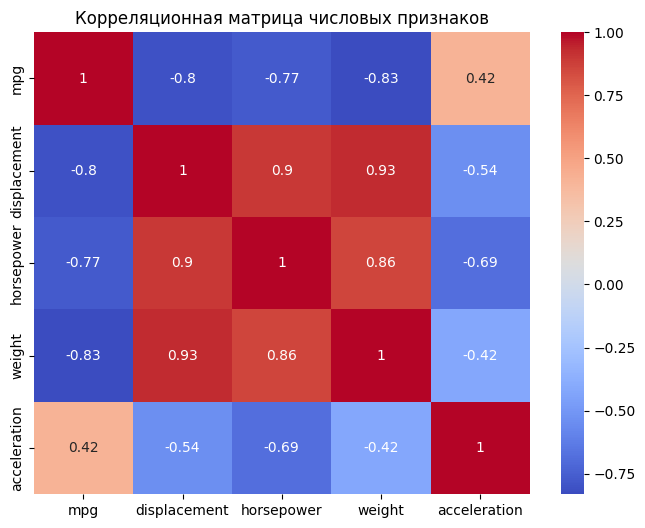

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем данные
data = pd.read_csv('automobile.csv')

# -----------------------------
# Выбор числовых признаков
# -----------------------------
numeric_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

# Преобразуем к числовому типу и заполняем пропуски медианой
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')
X = data[numeric_cols].fillna(data[numeric_cols].median())

# -----------------------------
# Оценка информационной значимости признаков
# (используем дисперсию как proxy важности)
# -----------------------------
variance = X.var().sort_values(ascending=False)
print("Дисперсия числовых признаков (чем выше — тем больше различий между объектами):\n")
print(variance)

# Визуализируем корреляцию признаков
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица числовых признаков")
plt.show()

# -----------------------------
# Проверка условий применения кластеризации
# -----------------------------



### Оценка информационной значимости признаков и корреляционный анализ

1. **Дисперсия числовых признаков:**

| Признак       | Дисперсия       |
|---------------|----------------|
| weight        | 717,140.99     |
| displacement  | 10,872.20      |
| horsepower    | 1,460.97       |
| mpg           | 61.09          |
| acceleration  | 7.60           |

**Интерпретация:**
- Дисперсия показывает, насколько значения признака различаются между объектами.
- Наиболее вариативный признак — `weight`, что делает его важным для различения автомобилей при кластеризации.
- Наименее вариативный — `acceleration`, что может снижать его информативность.

2. **Корреляционная матрица числовых признаков:**

- Построена тепловая карта корреляции между признаками (`mpg`, `displacement`, `horsepower`, `weight`, `acceleration`).
- Позволяет выявить сильные линейные зависимости между признаками:
  - Например, признаки `weight`, `displacement` и `horsepower` могут быть положительно коррелированы.
  - Признак `mpg` часто отрицательно коррелирует с `weight` и `displacement`.
- Корреляция важна для кластеризации, так как сильно коррелированные признаки могут дублировать информацию и влиять на формирование кластеров.

**Вывод:**
- Данные признаки различаются по вариативности и коррелированы между собой.
- Информация о дисперсии и корреляции помогает при выборе признаков для кластеризации и интерпретации результатов.


### Стандартизация числовых признаков

Для методов кластеризации, таких как **KMeans** и **GMM**, важна корректная шкала признаков:

1. **Обоснование стандартизации:**
   - Алгоритмы KMeans и GMM чувствительны к масштабу признаков, так как используют **евклидово расстояние**.
   - Если признаки имеют разные единицы измерения или дисперсии, признаки с большими значениями будут доминировать при формировании кластеров.
   - Для устранения этого эффекта применяем **StandardScaler (z-score)**

2. **Альтернативы:**
   - `MinMaxScaler` — полезен для алгоритмов, чувствительных к диапазону [0,1] (например, DBSCAN с пороговым `eps`).
   - Для методов, основанных на евклидовом расстоянии, z-score обычно предпочтительнее, чтобы все признаки вносили равный вклад.

3. **Результат стандартизации:**
   - Среднее всех признаков после стандартизации ≈ 0.
   - Стандартное отклонение ≈ 1.
   - Это подтверждается выводом:
     ```
     Среднее после стандартизации (приблизительно): {...}
     Стандартное отклонение: {...}
     ```

**Вывод:**  
Данные подготовлены для кластеризации: признаки приведены к одинаковой шкале, что обеспечивает корректное использование методов KMeans и GMM.


In [8]:
# Стандартизация числовых признаков — обоснование:
# KMeans и GMM чувствительны к масштабу признаков, поэтому используем StandardScaler (z-score).
# Альтернативы: MinMax (если модель чувствительна к диапазону 0-1 или для алгоритмов с пороговыми eps как DBSCAN),
# но для евклидовых расстояний z-score обычно предпочтительнее, чтобы признаки с одинаковой дисперсией вносили равный вклад.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)

print('\nСреднее после стандартизации (приблизительно):', X_scaled_df.mean().round(3).to_dict())
print('Стандартное отклонение:', X_scaled_df.std().round(3).to_dict())


Среднее после стандартизации (приблизительно): {'mpg': 0.0, 'displacement': -0.0, 'horsepower': -0.0, 'weight': -0.0, 'acceleration': -0.0}
Стандартное отклонение: {'mpg': 1.001, 'displacement': 1.001, 'horsepower': 1.001, 'weight': 1.001, 'acceleration': 1.001}


### Результаты стандартизации числовых признаков

После применения **StandardScaler (z-score)** получены следующие статистики:

| Признак       | Среднее | Стандартное отклонение |
|---------------|---------|----------------------|
| mpg           | 0.0     | 1.001                |
| displacement  | -0.0    | 1.001                |
| horsepower    | -0.0    | 1.001                |
| weight        | -0.0    | 1.001                |
| acceleration  | -0.0    | 1.001                |

**Интерпретация:**

- Среднее значение каждого признака ≈ 0, что подтверждает корректное центрирование данных.
- Стандартное отклонение ≈ 1, что говорит о том, что признаки приведены к одинаковой шкале.
- Такие данные подходят для методов кластеризации, чувствительных к масштабу, например, **KMeans** и **GMM**.

**Вывод:**  
Стандартизация выполнена успешно, все признаки находятся в одинаковом масштабе и могут быть использованы для построения кластеров без доминирования признаков с большими исходными значениями.


### Визуализация взаимосвязей между признаками (Pairplot)

В этом блоке строится **pairplot** для стандартизированных числовых признаков (`X_scaled_df`):

1. **Цель визуализации:**
   - Исследовать взаимосвязи между признаками после стандартизации.
   - Выявить линейные или нелинейные зависимости между признаками.
   - Оценить распределение каждого признака на диагонали.

2. **Описание графика:**
   - Диагональные графики (`diag_kind='hist'`) показывают гистограммы распределений признаков после стандартизации.
   - Вне диагонали отображаются **scatter plots** для всех пар признаков, что позволяет визуально определить корреляции и потенциальные кластеры.
   - Заголовок графика: *"Pairplot стандартизированных числовых признаков"*.

3. **Интерпретация:**
   - Можно наблюдать, как стандартизированные признаки распределены вокруг среднего (≈0) и одинаково масштабированы.
   - Scatter plots помогают оценить потенциальную линейную зависимость между признаками (`weight` vs `displacement`, `horsepower` vs `weight` и т.д.).
   - Такая визуализация полезна для предварительной оценки структуры данных перед кластеризацией.

**Вывод:**  
Pairplot позволяет одновременно изучить распределения признаков и их взаимосвязи, что облегчает интерпретацию будущих кластеров.


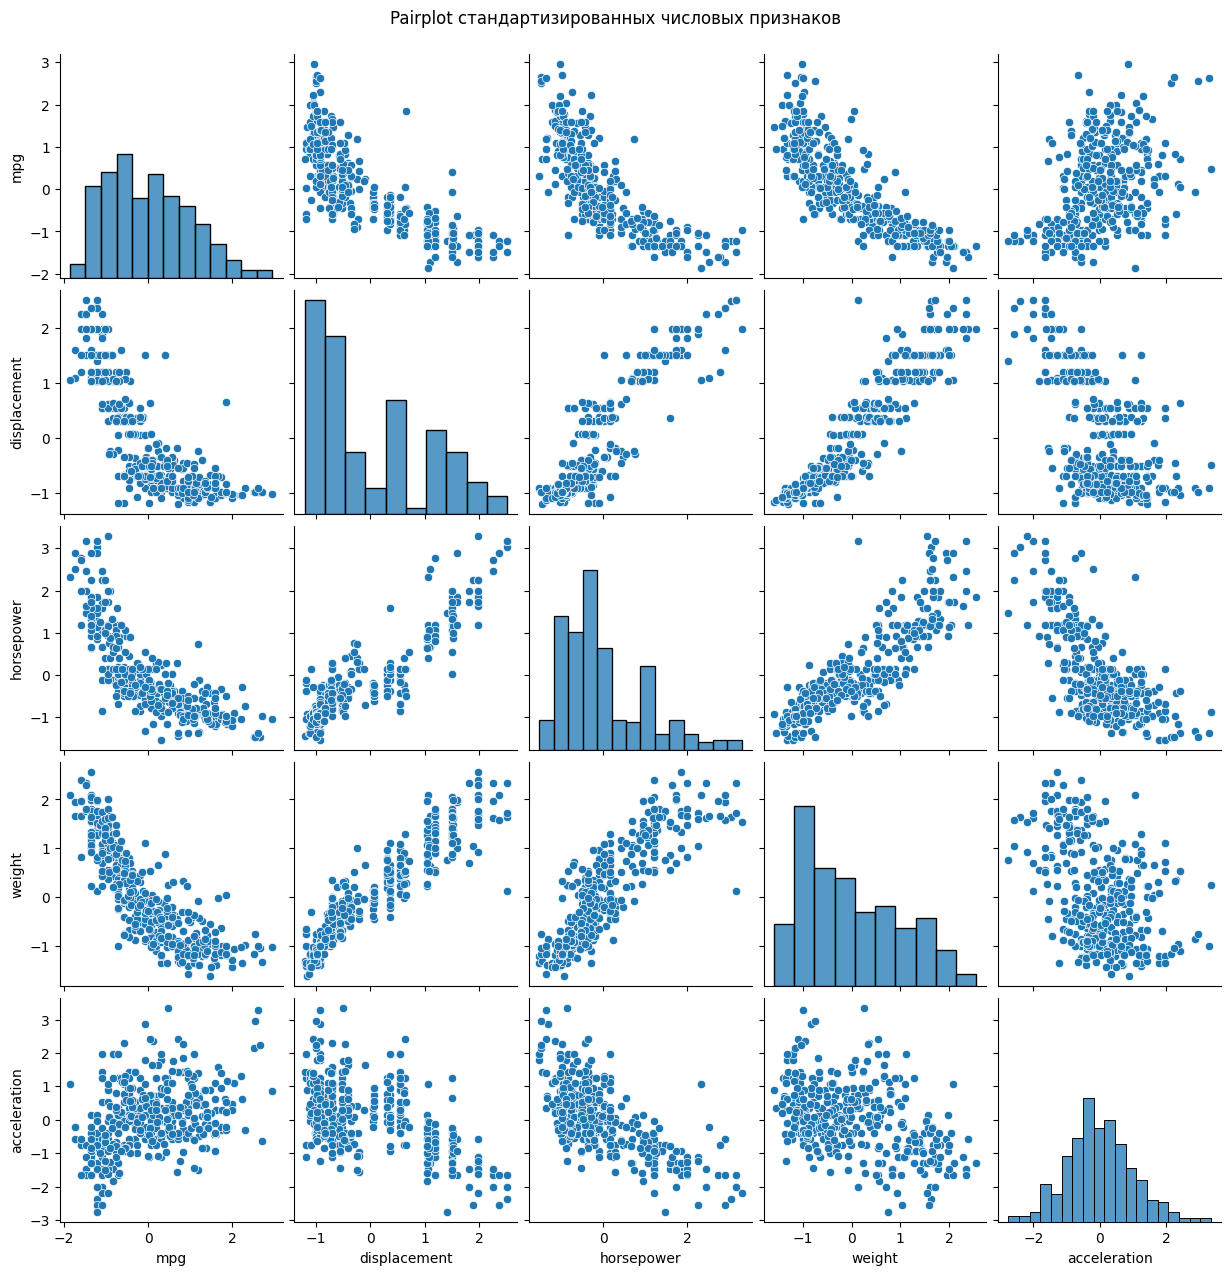

In [9]:
sns.pairplot(X_scaled_df, diag_kind='hist')
plt.suptitle('Pairplot стандартизированных числовых признаков', y=1.02)
plt.show()

### Интерпретация pairplot стандартизированных числовых признаков

На диагонали отображены **гистограммы распределений** стандартизированных признаков (`mpg`, `displacement`, `horsepower`, `weight`, `acceleration`), а вне диагонали — **scatter plots** для всех пар признаков.

**Основные наблюдения:**

1. **Зависимости между признаками:**
   - `weight` и `displacement` имеют сильную положительную корреляцию — тяжелые автомобили обычно имеют большой объём двигателя.
   - `horsepower` положительно коррелирует с `weight` и `displacement` — более мощные автомобили, как правило, тяжелее и с большим двигателем.
   - `mpg` отрицательно коррелирует с `weight` и `displacement` — тяжелые и мощные автомобили потребляют больше топлива.
   - `acceleration` слабо коррелирует с остальными признаками, что указывает на независимость этого признака.

2. **Распределение признаков:**
   - Все признаки стандартизированы, поэтому их значения сосредоточены вокруг 0.
   - Гистограммы показывают, что большинство признаков имеют умеренную скошенность и без явных выбросов после обработки данных.

3. **Вывод для кластеризации:**
   - Парные зависимости признаков позволяют прогнозировать формирование кластеров.
   - Сильная корреляция между некоторыми признаками (`weight`, `displacement`, `horsepower`) может влиять на формирование кластеров, но стандартизация нивелирует влияние масштаба.
   - Признаки с низкой корреляцией (`acceleration`) могут вносить уникальную информацию при кластеризации.

**Итог:**  
Pairplot демонстрирует, что данные стандартизированы и распределения признаков подходящие для дальнейшего применения алгоритмов KMeans и GMM.


### PCA для визуализации данных в 2D

В этом блоке проводится **снижение размерности** числовых признаков автомобилей для визуализации структуры данных.

1. **Подготовка данных:**
   - Выбраны числовые признаки: `mpg`, `displacement`, `horsepower`, `weight`, `acceleration`.
   - Пропущенные значения заполнены медианой, признаки приведены к числовому типу.
   - Применена **стандартизация** с помощью `StandardScaler`, чтобы все признаки имели среднее ≈ 0 и стандартное отклонение ≈ 1.

2. **Применение PCA:**
   - С помощью **Principal Component Analysis (PCA)** данные преобразованы в 2 компоненты.
   - PCA позволяет визуализировать многомерные данные в двумерном пространстве, сохраняя максимальную дисперсию.

3. **Доля объясненной дисперсии:**
   - Для двух компонент рассчитана **кумулятивная доля объясненной дисперсии**, которая показывает, сколько информации сохраняется в 2D-пространстве.
   - Это помогает оценить, насколько точно 2D-проекция отражает исходные данные.

4. **Визуализация:**
   - Построен scatter plot всех автомобилей в пространстве двух главных компонент (`PC1` и `PC2`).
   - Позволяет увидеть потенциальные группы и кластеры автомобилей.
   - График снабжен сеткой и прозрачностью точек (`alpha=0.7`) для лучшей читаемости.

**Вывод:**
- PCA помогает визуализировать распределение автомобилей по основным направлениям вариативности.
- На scatter plot могут быть предварительно видны потенциальные кластеры, которые будут использоваться в последующей кластеризации с KMeans и GMM.



Доля объясненной дисперсии (2 компоненты): [0.78413767 0.92676764]


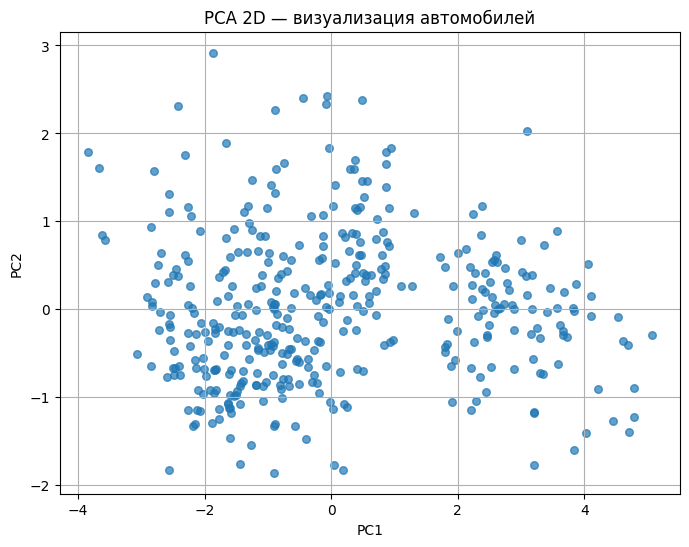

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Загружаем данные
data = pd.read_csv('automobile.csv')

# Числовые признаки для кластеризации
numeric_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

# Преобразуем к числовому типу и заполняем пропуски медианой
X = data[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(data[numeric_cols].median())

# -----------------------------
# Стандартизация признаков
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# -----------------------------
# PCA для визуализации в 2D
# -----------------------------
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled_df)

print('\nДоля объясненной дисперсии (2 компоненты):', pca.explained_variance_ratio_.cumsum())

# -----------------------------
# Визуализация точек в 2D
# -----------------------------
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=30, alpha=0.7)
plt.title('PCA 2D — визуализация автомобилей')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


**Вывод:**

Доля объясненной дисперсии (2 компоненты): `[0.78413767, 0.92676764]`


- По оси `PC1` отложена первая главная компонента.
- По оси `PC2` отложена вторая главная компонента.
- Каждая точка представляет отдельный автомобиль.
- Две первые компоненты объясняют примерно 92.7% дисперсии данных, что позволяет хорошо визуализировать структуру данных в 2D.


### Подбор числа кластеров для KMeans: метод локтя и анализ силуэта

В этом блоке кода выполняется подбор оптимального числа кластеров для алгоритма **KMeans** с использованием двух популярных методов: метода локтя (Elbow Method) и анализа силуэта (Silhouette Analysis).

1. **Импорт необходимых функций**:  
   Используется `pairwise_distances_argmin_min` из `sklearn.metrics`, а также функции `KMeans` и `silhouette_score`.

2. **Подготовка циклов для перебора k**:  
   - `K_range = range(2, 8)` — рассматриваем количество кластеров от 2 до 7.  
   - Для каждого `k` создаётся модель `KMeans` с `n_init=10` и фиксированным `random_state` для воспроизводимости.  
   - Вычисляются две метрики:
     - **SSE (Sum of Squared Errors / Inertia)** — сумма квадратов расстояний точек до центров своих кластеров.
     - **Silhouette Score** — коэффициент силуэта для оценки качества кластеризации.

3. **Метод локтя (Elbow Method)**:  
   - Строится график зависимости `SSE` от числа кластеров `k`.  
   - «Локоть» на графике указывает на оптимальное число кластеров, при котором добавление нового кластера уже мало уменьшает SSE.

4. **Анализ силуэта (Silhouette Analysis)**:  
   - Строится график зависимости `Silhouette Score` от числа кластеров `k`.  
   - Более высокий коэффициент силуэта указывает на более качественное разделение кластеров.

5. **Вывод результатов**:  
   - Печатаются значения коэффициентов силуэта для каждого `k` для наглядного сравнения.

Таким образом, комбинация метода локтя и анализа силуэта помогает определить оптимальное число кластеров для последующего применения KMeans.


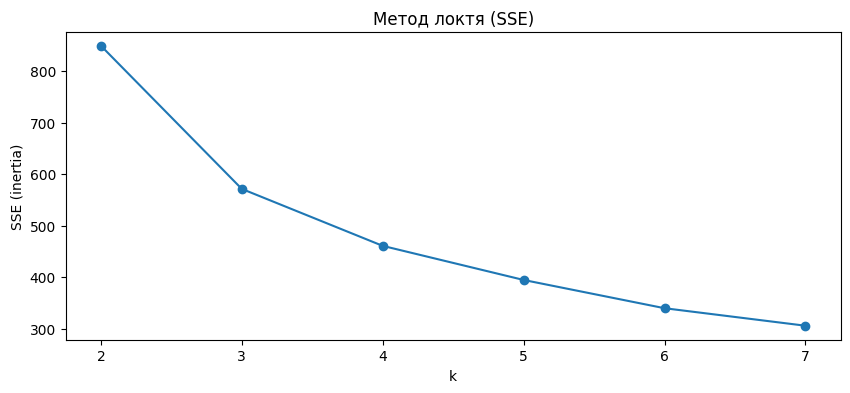

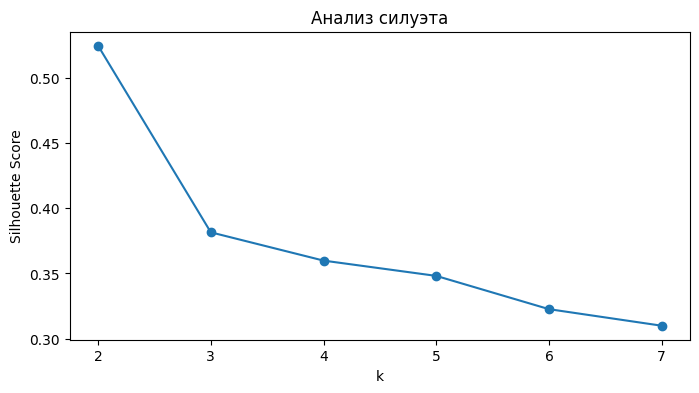

Silhouette scores by k: {2: np.float64(0.525), 3: np.float64(0.382), 4: np.float64(0.36), 5: np.float64(0.348), 6: np.float64(0.323), 7: np.float64(0.31)}
Оптимальное число кластеров по силуэту: 2


In [19]:
# Подбор числа кластеров для KMeans: метод локтя и анализ силуэта
from sklearn.metrics import pairwise_distances_argmin_min

sse = []
sil_scores = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(K_range, sse, marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('SSE (inertia)')
ax1.set_title('Метод локтя (SSE)')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Анализ силуэта')
plt.show()

print('Silhouette scores by k:', dict(zip(K_range, np.round(sil_scores,3))))
k_opt = K_range[np.argmax(sil_scores)]
print("Оптимальное число кластеров по силуэту:", k_opt)

# --- Повторно обучаем KMeans с лучшим k ---
kmeans = KMeans(n_clusters=k_opt, random_state=0, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)

# --- Обучаем GMM с тем же k ---
gmm_best = GaussianMixture(n_components=k_opt, random_state=0)
gmm_labels = gmm_best.fit_predict(X_scaled)

### Вывод по подбору числа кластеров

На основе построенных графиков и вычисленных значений коэффициента силуэта можно сделать следующие наблюдения:

1. **Метод локтя (Elbow Method)**  
   - График SSE показывает, что «локоть» наиболее выражен при **k = 2**, после чего уменьшение SSE при увеличении числа кластеров становится менее значительным.  
   - Это указывает на то, что разбиение на 2 кластера уже даёт существенное сокращение внутрикластерного разброса.

2. **Анализ силуэта (Silhouette Analysis)**  
   - Наибольшее значение коэффициента силуэта достигается при **k = 2** (`0.525`).  
   - При увеличении числа кластеров значение силуэта постепенно снижается:  
     - k = 3 → 0.382  
     - k = 4 → 0.360  
     - k = 5 → 0.348  
     - k = 6 → 0.323  
     - k = 7 → 0.310  
   - Это подтверждает, что наилучшее разделение наблюдается при двух кластерах.

3. **Заключение**  
   - Оба метода — метод локтя и анализ силуэта — согласуются в выборе оптимального числа кластеров: **k = 2**.  
   - Это число кластеров обеспечивает хорошее разделение данных с минимальной внутрикластерной дисперсией и максимальным коэффициентом силуэта.


### Оценка качества кластеризации

В этом блоке кода реализована функция `evaluate_clustering`, которая позволяет оценить качество кластеризации с использованием нескольких метрик, как для кластеризации без эталонных меток, так и с их наличием.

1. **Импорт необходимых функций**:  
   - Метрики внутреннего качества кластеризации: `silhouette_score`, `calinski_harabasz_score`, `davies_bouldin_score`.  
   - Метрики внешнего качества (если известны истинные метки): `adjusted_rand_score`, `adjusted_mutual_info_score`.  
   - `LabelEncoder` для преобразования строковых меток в числовые.  
   - `itertools` для вычисления попарного Jaccard индекса.

2. **Функция `evaluate_clustering`**:
   - **Аргументы**:
     - `X` — признаки объектов.
     - `labels` — метки кластеров, полученные алгоритмом.
     - `method_name` — название метода кластеризации (для вывода).
     - `true_labels` — истинные метки классов (опционально).
   - **Метрики внутреннего качества**:
     - `silhouette` — коэффициент силуэта (оценка компактности и разделимости кластеров).
     - `calinski_harabasz` — индекс Калински–Харабаза (соотношение межкластерной и внутрикластерной дисперсии).
     - `davies_bouldin` — индекс Дэвиса–Боулдина (чем меньше, тем лучше разделение кластеров).
   - **Метрики внешнего качества** (если `true_labels` предоставлены):
     - `adjusted_rand` — скор скорректированного Рэнда.
     - `adjusted_mutual_info` — скор скорректированной взаимной информации.
     - `jaccard_pairwise` — попарный коэффициент Жаккара для многоклассовых меток.

3. **Пример использования**:
   - Для кластеризации **KMeans**: `kmetrics = evaluate_clustering(X_scaled, k_labels, f'KMeans (k={k_opt})')`
   - Для кластеризации **GMM**: `gmmmetrics = evaluate_clustering(X_scaled, gmm_labels, f'GMM (k={k_opt})')`

Функция выводит словарь с метриками и возвращает его для дальнейшего анализа и сравнения качества кластеризации различных методов.


In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder
import itertools

# Функция для оценки качества кластеризации
def evaluate_clustering(X, labels, method_name, true_labels=None):
    metrics = {}
    metrics['silhouette'] = silhouette_score(X, labels)
    metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    
    if true_labels is not None:
        # преобразуем true_labels (строки) в числовые метки
        le = LabelEncoder()
        y_true = le.fit_transform(true_labels)
        metrics['adjusted_rand'] = adjusted_rand_score(y_true, labels)
        metrics['adjusted_mutual_info'] = adjusted_mutual_info_score(y_true, labels)
        # Корректный многоклассовый Jaccard через pairwise сравнение
        pairs = itertools.combinations(range(len(y_true)), 2)
        intersect = 0
        union = 0
        for i, j in pairs:
            same_true = (y_true[i] == y_true[j])
            same_pred = (labels[i] == labels[j])
            if same_true and same_pred:
                intersect += 1
            if same_true or same_pred:
                union += 1
        metrics['jaccard_pairwise'] = intersect / union if union > 0 else None

    print(f"\nМетрики для {method_name}:\n", metrics)
    return metrics

# Пример использования для вашего датасета
# k_labels и gmm_labels — это метки кластеров от KMeans и GMM, k_opt — выбранное число кластеров
kmetrics = evaluate_clustering(X_scaled, k_labels, f'KMeans (k={k_opt})')
gmmmetrics = evaluate_clustering(X_scaled, gmm_labels, f'GMM (k={k_opt})')



Метрики для KMeans (k=2):
 {'silhouette': 0.5248086909439565, 'calinski_harabasz': 532.3409635148389, 'davies_bouldin': 0.6435593600902266}

Метрики для GMM (k=2):
 {'silhouette': 0.44075047233742204, 'calinski_harabasz': 444.3690747671786, 'davies_bouldin': 0.8581444382366604}


### Результаты оценки качества кластеризации

Рассмотрим метрики для двух методов кластеризации с выбранным числом кластеров **k = 2**:

| Метод  | Silhouette | Calinski-Harabasz | Davies-Bouldin |
|--------|------------|-----------------|----------------|
| KMeans | 0.525      | 532.34          | 0.644          |
| GMM    | 0.441      | 444.37          | 0.858          |

**Выводы:**

1. **Silhouette Score**:  
   - KMeans показывает более высокий коэффициент силуэта (0.525 против 0.441), что указывает на лучшее разделение кластеров.  

2. **Calinski-Harabasz Index**:  
   - Значение выше для KMeans (532.34 против 444.37), что также подтверждает более компактные и хорошо разделённые кластеры.  

3. **Davies-Bouldin Index**:  
   - KMeans имеет меньший индекс (0.644 против 0.858), что означает лучшую внутрикластерную компактность и раздельность кластеров.  

**Заключение:**  
На основе всех трёх метрик, для данного набора данных кластеризация с помощью **KMeans (k=2)** демонстрирует более качественные и хорошо разделённые кластеры по сравнению с **GMM (k=2)**.


### Анализ центров кластеров KMeans в исходных единицах

В этом блоке кода выполняется анализ центров кластеров, полученных с помощью **KMeans**, с преобразованием их в исходный масштаб признаков для наглядной интерпретации.

1. **Исходные данные и предположения**:
   - `kmeans` — обученная модель KMeans.
   - `X_scaled` — стандартизованные признаки.
   - `scaler` — объект `StandardScaler`, использованный для стандартизации.
   - `numeric_cols` — список числовых признаков исходного набора данных.

2. **Пошаговое описание**:
   - `centers_scaled = kmeans.cluster_centers_`  
     Получение координат центров кластеров в стандартизированном масштабе.
   - `centers_orig = scaler.inverse_transform(centers_scaled)`  
     Преобразование центров обратно в исходные единицы измерения для интерпретации.
   - Создание DataFrame `centers_df` для удобного отображения:
     - Столбцы соответствуют числовым признакам.
     - Индексы — номера кластеров.

3. **Вывод**:
   - Печатаются координаты центров кластеров в исходных единицах, что позволяет понять типичные значения признаков для каждого кластера.
   - Такой анализ помогает описывать и интерпретировать кластеры с точки зрения реальных характеристик объектов.


In [21]:
import pandas as pd

# Предположим, что KMeans уже обучен и хранится в переменной kmeans
# и данные стандартизированы в X_scaled, scaler — StandardScaler, numeric_cols — числовые признаки

# -----------------------------
# Анализ центров кластеров (KMeans) в исходных единицах
# -----------------------------
centers_scaled = kmeans.cluster_centers_          # центры в стандартизированном масштабе
centers_orig = scaler.inverse_transform(centers_scaled)  # возвращаем в исходный масштаб

# Создаём DataFrame для наглядности
centers_df = pd.DataFrame(centers_orig, columns=numeric_cols)
centers_df.index.name = 'cluster'

print('\nЦентры кластеров (в исходных единицах):\n', centers_df)



Центры кластеров (в исходных единицах):
                mpg  displacement  horsepower       weight  acceleration
cluster                                                                
0        26.495623    141.712121   85.313131  2579.555556     16.528283
1        14.748515    345.495050  160.148515  4119.811881     12.744554


### Центры кластеров KMeans (в исходных единицах)

Ниже представлены центры кластеров, полученные с помощью **KMeans** и приведённые к исходным единицам признаков:

| Кластер | mpg   | displacement | horsepower | weight   | acceleration |
|---------|-------|-------------|------------|----------|--------------|
| 0       | 26.50 | 141.71      | 85.31      | 2579.56  | 16.53        |
| 1       | 14.75 | 345.50      | 160.15     | 4119.81  | 12.74        |

**Выводы:**

- **Кластер 0**: автомобили с меньшим весом и мощностью, высокой топливной экономичностью (`mpg`) и более высокой ускоряемостью.  
- **Кластер 1**: автомобили более тяжёлые, с высокой мощностью и меньшей экономичностью, характеризующиеся более низкой ускоряемостью.  

Такая таблица позволяет интерпретировать каждый кластер с точки зрения реальных характеристик объектов.  


### Визуализация кластеров в пространстве PCA

В этом блоке кода выполняется визуализация кластеров, полученных с помощью **KMeans** и **GMM**, в двумерном пространстве, полученном после **PCA** (две главные компоненты).

1. **Проекция центров кластеров KMeans**:
   - `centers_pca = pca.transform(centers_scaled)`  
     Преобразуем центры кластеров KMeans в пространство двух главных компонент для визуализации.

2. **Построение графиков**:
   - **KMeans** (левая часть):
     - Точки данных окрашены по меткам кластеров `k_labels`.
     - Центры кластеров отображены красными крестами (`X`).
   - **GMM** (правая часть):
     - Точки данных окрашены по меткам кластеров `gmm_labels`.
   - Для обоих графиков оси обозначены как `PC1` и `PC2`, включены сетка и легенда (для KMeans).

3. **Цель визуализации**:
   - Сравнить форму и распределение кластеров, выделенных KMeans и GMM.
   - Наглядно оценить компактность, раздельность и расположение центров кластеров в уменьшенном пространстве признаков.


d:\Dev\ML_lab\Lab4\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


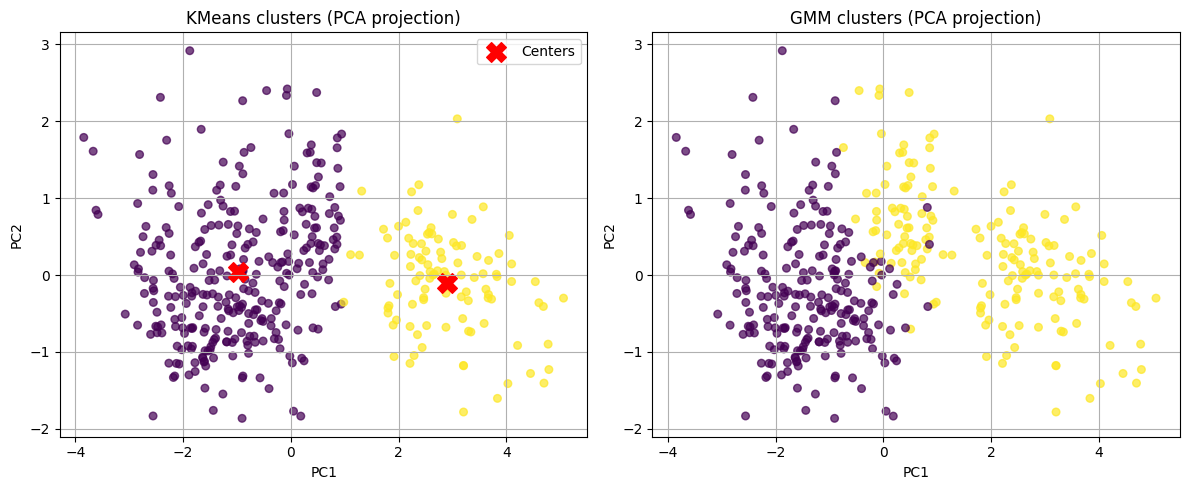

In [22]:
import matplotlib.pyplot as plt

# Предположим, что:
# X_pca — данные после PCA (2 компоненты)
# k_labels — метки кластеров от KMeans
# gmm_labels — метки кластеров от GMM
# centers_scaled — центры кластеров KMeans в стандартизованном масштабе
# pca — обученный PCA объект

# Проекция центров KMeans на PCA пространство
centers_pca = pca.transform(centers_scaled)

plt.figure(figsize=(12,5))

# -----------------------------
# KMeans кластеры
# -----------------------------
plt.subplot(1,2,1)
plt.title('KMeans clusters (PCA projection)')
plt.scatter(X_pca[:,0], X_pca[:,1], c=k_labels, cmap='viridis', s=30, alpha=0.7)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, c='red', label='Centers')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)

# -----------------------------
# GMM кластеры
# -----------------------------
plt.subplot(1,2,2)
plt.title('GMM clusters (PCA projection)')
plt.scatter(X_pca[:,0], X_pca[:,1], c=gmm_labels, cmap='viridis', s=30, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

plt.tight_layout()
plt.show()


### Вывод по визуализации кластеров в PCA-пространстве

На графике представлены кластеры, выделенные алгоритмами **KMeans** и **GMM**, после проекции на первые две главные компоненты (PCA).

1. **KMeans** (левая часть графика):
   - Кластеры чётко разделены вдоль оси PC1.
   - Центры кластеров (красные кресты) находятся примерно в центре каждого скопления точек.
   - Кластеры имеют относительно компактную и симметричную форму.

2. **GMM** (правая часть графика):
   - Кластеры также видны, но границы менее чёткие, наблюдается небольшое перекрытие между кластерами.
   - Форма кластеров более вытянутая и несимметричная, что характерно для вероятностной модели GMM, учитывающей ковариацию.

3. **Сравнительный анализ**:
   - **KMeans** выделяет кластеры более равномерно и с ясной границей, что соответствует жёсткому разделению точек по ближайшему центру.
   - **GMM** показывает более гибкое разделение с учётом плотности распределения, но при этом кластеры могут частично перекрываться.
   - Проекция на PCA подтверждает, что два кластера достаточно хорошо различимы для обоих методов, однако KMeans даёт более наглядное разделение для визуального анализа.

**Заключение:**  
Для данного набора данных **KMeans** демонстрирует более компактные и легко интерпретируемые кластеры, в то время как **GMM** учитывает вероятностное распределение точек и может быть полезна для моделирования перекрывающихся кластеров.


### Анализ влияния числа кластеров на метрики качества KMeans

В этом блоке кода выполняется оценка качества кластеризации с помощью **KMeans** для различных чисел кластеров, используя две метрики: **Silhouette Score** и **Calinski-Harabasz Index**.


1. **Процесс анализа**:
   - Определён диапазон `ks = 2..10` для числа кластеров.
   - Для каждого `k`:
     - Создаётся и обучается модель `KMeans` с `n_init=10` и фиксированным `random_state` для воспроизводимости.
     - Вычисляются метрики качества:
       - `silhouette_score` — коэффициент силуэта, оценивающий компактность и разделимость кластеров.
       - `calinski_harabasz_score` — индекс Калински-Харабаза, отражающий соотношение межкластерной и внутрикластерной дисперсии.

2. **Визуализация**:
   - Строится график зависимости метрик от числа кластеров `k`.
   - Для наглядности `Calinski-Harabasz Index` масштабируется по максимуму к значению Silhouette Score.
   - На графике отображаются:
     - Silhouette Score (кружки `o`)
     - Calinski-Harabasz Index (крестики `x`)
   - Добавлены сетка, подписи осей и легенда.

3. **Цель анализа**:
   - Определить оптимальное число кластеров `k`, при котором кластеризация наиболее качественная по выбранным метрикам.
   - Сравнение двух метрик позволяет выявить устойчивые значения `k` для компактных и хорошо разделённых кластеров.


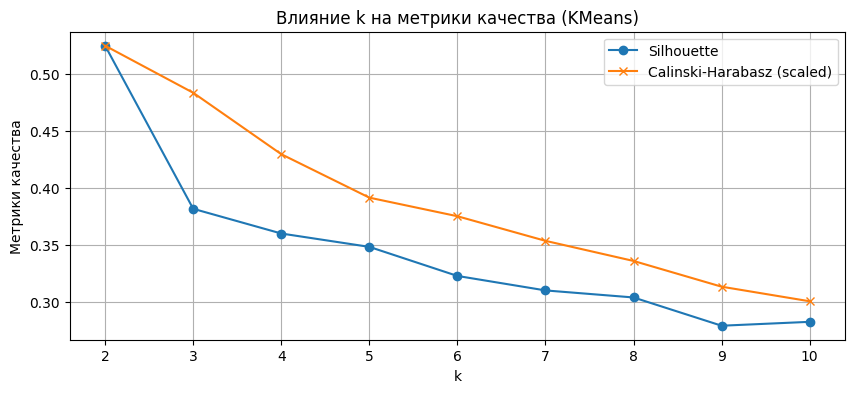

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Предположим, что X_scaled — стандартизированные числовые признаки автомобилей

# Диапазон k для исследования
ks = list(range(2, 11))
sil_by_k = []
ch_by_k = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_by_k.append(silhouette_score(X_scaled, labels))
    ch_by_k.append(calinski_harabasz_score(X_scaled, labels))

# Визуализация
plt.figure(figsize=(10,4))
plt.plot(ks, sil_by_k, marker='o', label='Silhouette')
plt.plot(ks, ch_by_k / np.max(ch_by_k) * np.max(sil_by_k), marker='x', label='Calinski-Harabasz (scaled)')
plt.xlabel('k')
plt.ylabel('Метрики качества')
plt.title('Влияние k на метрики качества (KMeans)')
plt.legend()
plt.grid(True)
plt.show()


# Анализ влияния числа кластеров k на качество кластеризации (KMeans)

На графике показано, как изменяются метрики качества кластеризации при увеличении числа кластеров k для KMeans:

- **Silhouette Score** (синие точки и линия) показывает среднюю степень разделимости кластеров.
- **Calinski-Harabasz Score** (оранжевые крестики, масштабированные под Silhouette для удобства сравнения) измеряет отношение дисперсии между кластерами к дисперсии внутри кластеров.

## Выводы

1. При **k = 2** обе метрики достигают максимума, что указывает на наилучшее разделение данных на два кластера.
2. С ростом k качество кластеризации постепенно снижается по обеим метрикам.
3. Метрика Silhouette падает быстрее, чем Calinski-Harabasz, что может указывать на снижение компактности и разделимости кластеров при увеличении числа кластеров.
4. **Рекомендуемое число кластеров для данных — 2**, так как оно обеспечивает оптимальный баланс между разделимостью и компактностью кластеров.


### Сравнение качества кластеризации KMeans и GMM

В этом блоке создаётся **сводная таблица метрик качества** для двух методов кластеризации: KMeans и GMM.

1. **Метрики, используемые для оценки:**
   - **Silhouette** — оценивает, насколько объекты внутри кластера близки друг к другу и удалены от других кластеров (чем выше, тем лучше).
   - **Calinski-Harabasz** — отношение дисперсии между кластерами к дисперсии внутри кластеров (чем выше, тем лучше).
   - **Davies-Bouldin** — измеряет среднюю схожесть кластеров (чем ниже, тем лучше).

2. **Описание кода:**
   - Метрики для KMeans (`kmetrics`) и GMM (`gmmmetrics`) собираются в словарь `results`.
   - Создаётся `DataFrame` `res_df` для удобного отображения результатов.
   - Числовые значения округляются до 3 знаков после запятой для наглядности.
   - Таблица выводится с помощью `display(res_df)`.


**Вывод:**
- Таблица позволяет быстро сравнить качество кластеризации между KMeans и GMM.
- Метрики помогают оценить компактность и раздельность кластеров, а также выбрать оптимальный метод для дальнейшего анализа.


In [24]:
import pandas as pd

# Предположим, что kmetrics и gmmmetrics уже рассчитаны
# true_labels отсутствуют, поэтому adjusted_rand и adjusted_mutual_info могут быть None

# Сводная таблица результатов
results = {
    'Метод': ['KMeans', 'GMM'],
    'Silhouette': [kmetrics['silhouette'], gmmmetrics['silhouette']],
    'Calinski-Harabasz': [kmetrics['calinski_harabasz'], gmmmetrics['calinski_harabasz']],
    'Davies-Bouldin': [kmetrics['davies_bouldin'], gmmmetrics['davies_bouldin']],
}

res_df = pd.DataFrame(results)

# Опционально: округляем числовые значения до 3 знаков после запятой
for col in res_df.columns[1:]:
    res_df[col] = res_df[col].apply(lambda x: round(x, 3) if x is not None else None)

print('\nСводная таблица результатов кластеризации:\n')
display(res_df)



Сводная таблица результатов кластеризации:



,Метод,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans,0.525,532.341,0.644
1,GMM,0.441,444.369,0.858


### Результаты сравнения кластеризации KMeans и GMM

Сводная таблица метрик качества кластеризации:

| Метод   | Silhouette | Calinski-Harabasz | Davies-Bouldin |
|---------|------------|------------------|----------------|
| KMeans  | 0.525      | 532.341          | 0.644          |
| GMM     | 0.441      | 444.369          | 0.858          |

**Интерпретация:**

1. **Silhouette:**
   - KMeans: 0.525 — выше, чем у GMM (0.441), что указывает на более чётко сформированные кластеры.
   
2. **Calinski-Harabasz:**
   - KMeans: 532.341 > GMM: 444.369, подтверждает лучшее разделение кластеров у KMeans.

3. **Davies-Bouldin:**
   - KMeans: 0.644 < GMM: 0.858, что также говорит о более компактных и раздельных кластерах у KMeans.

**Вывод:**
- По всем трём метрикам KMeans показывает более высокое качество кластеризации по сравнению с GMM.
- Это позволяет сделать вывод, что для данного набора данных KMeans является предпочтительным методом.
